# homeless_shelter_demographics.ipynb

### CSc-59866 - Senior Design - Prof. Etemadpour

* Purpose: exploratory data analysis for shelter demographics dataset from NYC Open Data
* Date: 2021-03-19
* Authors: Xin Chen, Ian S. McBride, Lifu Tao

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-s-mcb/ai-hw-1-jupyter-notebook/blob/master/homeless_shelter_demographics.ipynb)

In [ ]:
!pip install -r https://raw.githubusercontent.com/ian-s-mcb/ai-hw-1-jupyter-notebook/master/requirements.txt

In [2]:
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sn
from sodapy import Socrata
from urllib.request import urlopen

### Access dataset

In [3]:
# Access dataset via sodapy with a token
client = Socrata(
    'data.cityofnewyork.us',
    'o37N4aJqM70C9bwiqcfTNFIRB',
)

# Monthly shelter demographics data (city-wide)
# From: https://data.cityofnewyork.us/Social-Services/DHS-Data-Dashboard/5e9h-x6ak
results = client.get('5e9h-x6ak', limit=2000)
df_original = pd.DataFrame.from_records(results, index='report_date')

### Display original data

In [4]:
# Check row count (should be 66)
display(df_original.info())
display(df_original)

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2015-07-01T00:00:00.000 to 2020-12-01T00:00:00.000
Data columns (total 57 columns):
 #   Column                                                                                   Non-Null Count  Dtype 
---  ------                                                                                   --------------  ----- 
 0   fwc_avg_daily_census                                                                     66 non-null     object
 1   fwc_avg_daily_census_1                                                                   66 non-null     object
 2   fwc_avg_daily_census_2                                                                   66 non-null     object
 3   af_avg_daily_census_individual                                                           66 non-null     object
 4   sa_avg_daily_census_individual                                                           66 non-null     object
 5   sa_avg_daily_census_individual_1   

None

,fwc_avg_daily_census,fwc_avg_daily_census_1,fwc_avg_daily_census_2,af_avg_daily_census_individual,sa_avg_daily_census_individual,sa_avg_daily_census_individual_1,sa_avg_daily_census_individual_2,fwc_unique_individuals_by,fwc_unique_individuals_by_1,fwc_unique_individuals_by_2,...,sa_race_ethnicity_hoh_total,fwc_number_of_school_aged,fwc_average_school_attendance,fwc_percent_of_families,home_stat_clients_placed_into_permanent_housing_transitional_housing_and_other_settings,total_homebase_enrollments,fwc_total_shelter_placements,af_total_shelter_placements,sa_total_shelter_placements,sa_shelter_exits_into_supportive_housing
report_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01T00:00:00.000,16591,22955,39546,4446,8624,3346,11970,11187,10730,3542,...,15503,18675,NA,0.52,NA,2455,676,88,709,127
2015-08-01T00:00:00.000,16731,23188,39919,4460,8653,3433,12086,11345,10495,3635,...,16615,18952,NA,0.49,NA,2228,717,67,708,89
2015-09-01T00:00:00.000,16902,23428,40330,4487,8755,3492,12247,11386,11093,3625,...,15813,19044,0.845,0.51,NA,2250,732,63,762,148
2015-10-01T00:00:00.000,16949,23384,40333,4535,8920,3557,12477,11304,10879,3580,...,16030,18634,0.857,0.56,NA,2241,646,55,822,134
2015-11-01T00:00:00.000,17060,23458,40518,4556,9107,3578,12685,11275,10863,3543,...,15961,18518,0.845,0.48,NA,1978,530,54,687,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01T00:00:00.000,13907,18568,32475,4613,13163,4522,17685,9004,8522,2599,...,21059,15855,NA,0.55,389,2126,612,50,459,62
2020-09-01T00:00:00.000,13724,18356,32080,4480,13264,4540,17805,8943,8449,2581,...,21216,15596,68%,0.55,581,2240,636,46,532,102
2020-10-01T00:00:00.000,13607,18221,31828,4401,13392,4525,17917,8856,8248,2536,...,21535,15211,74%,0.54,661,2182,509,43,509,114


### Clean shelter data

In [5]:
columns = [
    'avg-daily-family-with-children-adults',
    'avg-daily-family-with-children-children',
    'avg-daily-family-with-children',
    'avg-daily-adult-family',
    'avg-daily-single-adult-sex-male',
    'avg-daily-single-adult-sex-female',
    'avg-daily-single-adult',
    'individuals-family-with-children-age-0-to-5',
    'individuals-family-with-children-age-6-to-13',
    'individuals-family-with-children-age-14-to-17',
    'individuals-family-with-children-age-18-to-20',
    'individuals-family-with-children-age-21-to-29',
    'individuals-family-with-children-age-30-to-44',
    'individuals-family-with-children-age-45-to-64',
    'individuals-family-with-children-age-65-and-above',
    'individuals-family-with-children',
    'individuals-adult-family-age-18-to-20',
    'individuals-adult-family-age-21-to-29',
    'individuals-adult-family-age-30-to-44',
    'individuals-adult-family-age-45-to-64',
    'individuals-adult-family-age-65-and-above',
    'individuals-adult-family',
    'individuals-single-adult-age-18-to-29',
    'individuals-single-adult-age-30-to-44',
    'individuals-single-adult-age-45-to-64',
    'individuals-single-adult-age-65-and-above',
    'individuals-single-adult',
    'head-of-household-family-with-children-race-asian-pacific-islander',
    'head-of-household-family-with-children-race-black-non-hispanic',
    'head-of-household-family-with-children-race-hispanic',
    'head-of-household-family-with-children-race-native-american',
    'head-of-household-family-with-children-race-white-non-hispanic',
    'head-of-household-family-with-children-race-unknown',
    'head-of-household-family-with-children',
    'head-of-household-adult-family-race-asian-pacific-islander',
    'head-of-household-adult-family-race-black-non-hispanic',
    'head-of-household-adult-family-race-hispanic',
    'head-of-household-adult-family-race-native-american',
    'head-of-household-adult-family-race-white-non-hispanic',
    'head-of-household-adult-family-race-unknown',
    'head-of-household-adult-family',
    'head-of-household-single-adult-race-asian-pacific-islander',
    'head-of-household-single-adult-race-black-non-hispanic',
    'head-of-household-single-adult-race-hispanic',
    'head-of-household-single-adult-race-native-american',
    'head-of-household-single-adult-race-white-non-hispanic',
    'head-of-household-single-adult-race-unknown',
    'head-of-household-single-adult',
    'individuals-family-with-children-age-school-age',
    'school-attendance-percent',
    'percent-families-with-school-placement',
    'home-stat-clients-placed-into-housing',
    'homebase-enrollments',
    'placed-outside-shelter-case-family-with-children',
    'placed-outside-shelter-case-adult-family',
    'placed-outside-shelter-case-single-adult',
    'placed-in-supportive-housing-single-adult',
]
columns_nested = {
    'avg-daily-family-with-children': [
        'avg-daily-family-with-children-adults',
        'avg-daily-family-with-children-children',
        'avg-daily-family-with-children',
    ],
    'avg-daily-adult-family': [
        'avg-daily-adult-family',    
    ],
    'avg-daily-single-adult': [
        'avg-daily-single-adult-sex-male',
        'avg-daily-single-adult-sex-female',
        'avg-daily-single-adult',
    ],
    'individuals-family-with-children-age': [
        'individuals-family-with-children-age-0-to-5',
        'individuals-family-with-children-age-6-to-13',
        'individuals-family-with-children-age-14-to-17',
        'individuals-family-with-children-age-18-to-20',
        'individuals-family-with-children-age-21-to-29',
        'individuals-family-with-children-age-30-to-44',
        'individuals-family-with-children-age-45-to-64',
        'individuals-family-with-children-age-65-and-above',
        'individuals-family-with-children',
    ],
    'individuals-adult-family-age': [
        'individuals-adult-family-age-18-to-20',
        'individuals-adult-family-age-21-to-29',
        'individuals-adult-family-age-30-to-44',
        'individuals-adult-family-age-45-to-64',
        'individuals-adult-family-age-65-and-above',
        'individuals-adult-family',
    ],
    'individuals-single-adult-age': [
        'individuals-single-adult-age-18-to-29',
        'individuals-single-adult-age-30-to-44',
        'individuals-single-adult-age-45-to-64',
        'individuals-single-adult-age-65-and-above',
        'individuals-single-adult',
    ],
    'head-of-household-family-with-children-race' : [
        'head-of-household-family-with-children-race-asian-pacific-islander',
        'head-of-household-family-with-children-race-black-non-hispanic',
        'head-of-household-family-with-children-race-hispanic',
        'head-of-household-family-with-children-race-native-american',
        'head-of-household-family-with-children-race-white-non-hispanic',
        'head-of-household-family-with-children-race-unknown',
        'head-of-household-family-with-children',      
    ],
    'head-of-household-adult-family-race': [
        'head-of-household-adult-family-race-asian-pacific-islander',
        'head-of-household-adult-family-race-black-non-hispanic',
        'head-of-household-adult-family-race-hispanic',
        'head-of-household-adult-family-race-native-american',
        'head-of-household-adult-family-race-white-non-hispanic',
        'head-of-household-adult-family-race-unknown',
        'head-of-household-adult-family',
    ],
    'head-of-household-single-adult-race': [
        'head-of-household-single-adult-race-asian-pacific-islander',
        'head-of-household-single-adult-race-black-non-hispanic',
        'head-of-household-single-adult-race-hispanic',
        'head-of-household-single-adult-race-native-american',
        'head-of-household-single-adult-race-white-non-hispanic',
        'head-of-household-single-adult-race-unknown',
        'head-of-household-single-adult',
    ],
    'individuals-family-with-children-age-school-age': [
        'individuals-family-with-children-age-school-age',
    ],
    'school-attendance-percent': [
        'school-attendance-percent',
    ],
    'percent-families-with-school-placement': [
        'percent-families-with-school-placement',
    ],
    'home-stat-clients-placed-into-housing': [
        'home-stat-clients-placed-into-housing',
    ],
    'homebase-enrollments': [
        'homebase-enrollments',
    ],
    'placed-outside-shelter-case': [
        'placed-outside-shelter-case-family-with-children',
        'placed-outside-shelter-case-adult-family',
        'placed-outside-shelter-case-single-adult',
    ],
    'placed-in-supportive-housing-single-adult': [
        'placed-in-supportive-housing-single-adult',
    ],
}
print('Column count for columns and column_nested should match')
len(columns), sum([len(value) for _, value in columns_nested.items()])

Column count for columns and column_nested should match


(57, 57)

In [6]:
# Select years 2019 and 2020
data_selection = df_original.loc['2019-01-01':].values

# Fix index format, column names
df = pd.DataFrame(
    data_selection,
    index=pd.date_range(start='2019-01-31', freq='m', periods=24),
    columns=columns,
)

# Helpers for cleaning
def clean_school_attendance(v):
    if v.find('NA') != -1:
        return pd.NA
    elif v.find('%') != -1:
        return float(v[0:-1]) / 100
    else:    
        return float(v)
clean_home_stat = lambda v: v.replace(',', '')

# Apply helpers
df['school-attendance-percent'] = df['school-attendance-percent'].apply(clean_school_attendance)
df['home-stat-clients-placed-into-housing'] = df['home-stat-clients-placed-into-housing'].apply(clean_home_stat)

# Convert datatype
column_dtype = {c: 'int' for c in columns}
column_dtype = {**column_dtype, 'school-attendance-percent': object, 'percent-families-with-school-placement': float}
df = df.astype(column_dtype)
display(df)
display(df.info())

,avg-daily-family-with-children-adults,avg-daily-family-with-children-children,avg-daily-family-with-children,avg-daily-adult-family,avg-daily-single-adult-sex-male,avg-daily-single-adult-sex-female,avg-daily-single-adult,individuals-family-with-children-age-0-to-5,individuals-family-with-children-age-6-to-13,individuals-family-with-children-age-14-to-17,...,head-of-household-single-adult,individuals-family-with-children-age-school-age,school-attendance-percent,percent-families-with-school-placement,home-stat-clients-placed-into-housing,homebase-enrollments,placed-outside-shelter-case-family-with-children,placed-outside-shelter-case-adult-family,placed-outside-shelter-case-single-adult,placed-in-supportive-housing-single-adult
2019-01-31,16943,22429,39371,5397,11873,4470,16342,10897,10352,3242,...,20612,15732,0.827,0.520697,358,2569,703,49,761,163
2019-02-28,16765,22191,38956,5367,12040,4476,16516,10740,10193,3228,...,20436,15439,0.843,0.515408,335,2297,741,60,709,130
2019-03-31,16619,21897,38517,5305,12045,4436,16481,10673,10100,3191,...,20863,15178,0.852,0.540348,304,2594,783,74,805,160
2019-04-30,16093,21174,37267,5261,12052,4425,16477,10544,9972,3143,...,20734,14893,0.86,0.530000,292,2812,1121,35,762,170
2019-05-31,15867,20839,36706,5313,11968,4349,16317,10291,9634,3035,...,20593,14263,0.85,0.550000,258,2488,771,48,842,173
2019-06-30,15789,20758,36547,5331,11818,4349,16167,10355,9495,3002,...,20457,14028,0.78,0.610000,236,2629,684,34,777,118
2019-07-31,15870,20891,36761,5288,11754,4346,16099,10581,9596,3043,...,20373,15298,<NA>,0.680000,320,2777,696,48,795,129
2019-08-31,16096,21251,37347,5274,11813,4398,16211,10795,9911,3074,...,20524,15583,<NA>,0.650000,334,2885,735,46,843,146
2019-09-30,16302,21555,37857,5299,11868,4512,16380,10814,9900,3077,...,20406,16777,0.860387,0.560000,317,2114,668,44,737,92
2019-10-31,16379,21730,38108,5329,11982,4562,16545,10811,9887,3065,...,20769,16612,0.868619,0.560000,416,3071,664,35,818,150


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2019-01-31 to 2020-12-31
Freq: M
Data columns (total 57 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   avg-daily-family-with-children-adults                               24 non-null     int64  
 1   avg-daily-family-with-children-children                             24 non-null     int64  
 2   avg-daily-family-with-children                                      24 non-null     int64  
 3   avg-daily-adult-family                                              24 non-null     int64  
 4   avg-daily-single-adult-sex-male                                     24 non-null     int64  
 5   avg-daily-single-adult-sex-female                                   24 non-null     int64  
 6   avg-daily-single-adult                                              24 non-null     int6

None

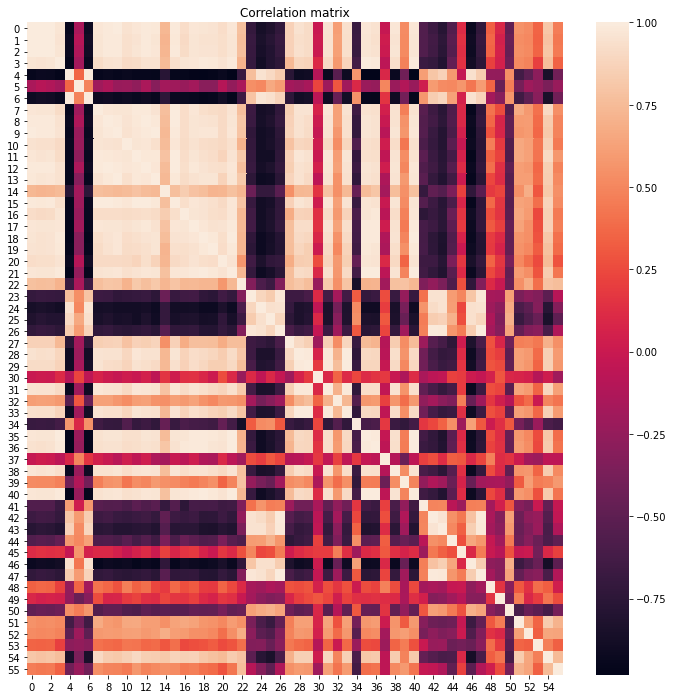

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)

corr_matrix = df.corr().values
_ = sn.heatmap(corr_matrix, ax=ax)
_ = ax.set_title('Correlation matrix')

### Store datasets locally

In [8]:
os.makedirs('./data', exist_ok=True)
df.to_pickle('./data/shelter_demographics.pickle')